<p>Mô hình dựa trên mô hình Transformer tuy nhiên sẽ không có Positional Encoding mà dựa vào 2 bô Encoder và Decoder để đưa ra predict: </p>

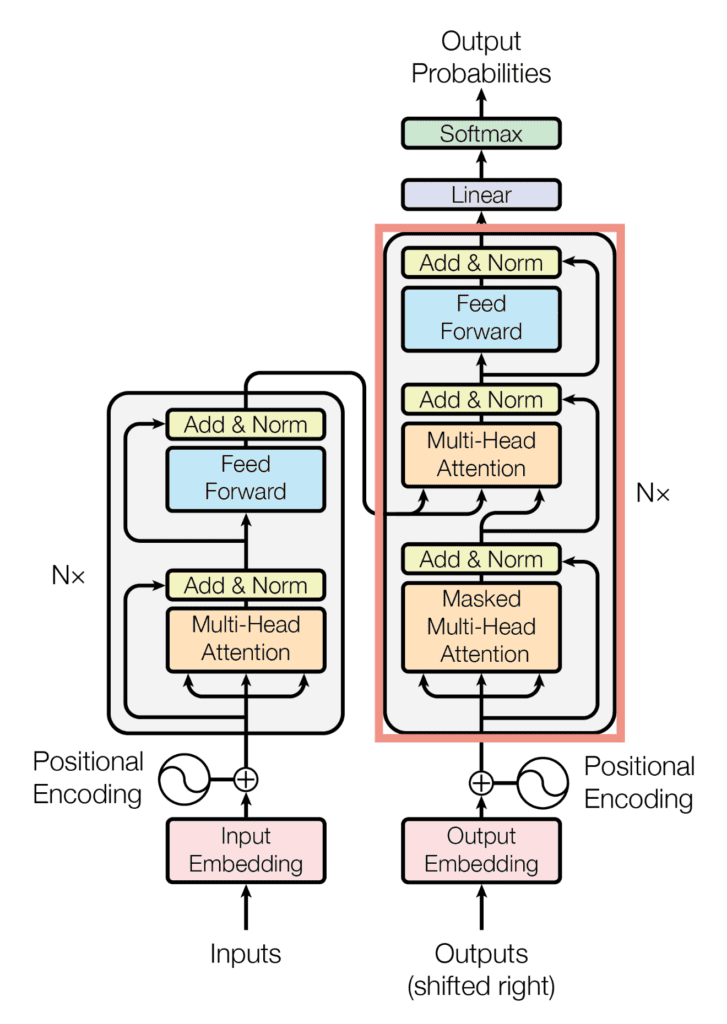

In [118]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split

<p>KHỞI TẠO GIÁ TRỊ VA NƠI LƯU TRỮ</p>

In [119]:
NUM_CLASSES = 8

In [120]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier'
model_json_path = 'model/keypoint_classifier/json'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'
tfjson_save_path = 'model/keypoint_classifier/keypoint_classifier.json'
tfbin_save_path = 'model/keypoint_classifier/keypoint_classifier.bin'

<p>MULTIHEAD ATTENTION with SCALE-DOT</p>

In [121]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0
        self.projection_dim = embed_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        # print(output)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  
        key = self.key_dense(inputs)  
        value = self.value_dense(inputs)  
        query = self.separate_heads(query, batch_size)  
        key = self.separate_heads(key, batch_size)  
        value = self.separate_heads(value, batch_size)  
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  
        output = self.combine_heads(concat_attention)  
        return output
    
# attention_layer = MultiHeadSelfAttention(embed_dim=128, num_heads=8)

# # Generate a sample input tensor
# inputs = tf.random.normal((2, 42))
# print(inputs)

# # Call the attention layer
# output = attention_layer(inputs)

# # Check the shape of the output
# print("Output shape:", output.shape)

<p>NHÚNG VỊ TRÍ CÁC ĐIỂM</p>

In [122]:
# class PositionalEncoding(tf.keras.layers.Layer):
#     def __init__(self, sequence_length, embed_dim):
#         super(PositionalEncoding, self).__init__()
#         self.positional_encoding = self.positional_encoding(sequence_length, embed_dim)

#     def get_angles(self, position, i, embed_dim):
#         angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(embed_dim, tf.float32))
#         return position * angles

#     def positional_encoding(self, position, embed_dim):
#         angle_rads = self.get_angles(
#             position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
#             i=tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :],
#             embed_dim=embed_dim,
#         )
#         # apply sin to even indices in the array; 2i
#         sines = tf.math.sin(angle_rads[:, 0::2])
#         # apply cos to odd indices in the array; 2i+1
#         cosines = tf.math.cos(angle_rads[:, 1::2])
#         pos_encoding = tf.concat([sines, cosines], axis=-1)
#         pos_encoding = pos_encoding[tf.newaxis, ...]
#         return tf.cast(pos_encoding, tf.float32)

#     def call(self, inputs):
#         return inputs + self.positional_encoding[:, : tf.shape(inputs)[1], :]

<p>XÂY DỰNG MÔ HÌNH TRANSFORMER</p>

In [123]:

class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(EncoderBlock, self).__init__()
        self.att = MultiHeadSelfAttention(num_heads=num_heads, embed_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# class DecoderBlock(tf.keras.layers.Layer):
#     def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
#         super(DecoderBlock, self).__init__()
#         self.att1 = MultiHeadSelfAttention(embed_dim,num_heads)
#         self.att2 = MultiHeadSelfAttention(embed_dim,num_heads)
#         self.ffn = tf.keras.Sequential(
#             [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
#         )
#         self.layernorm1 = LayerNormalization(epsilon=1e-6)
#         self.layernorm2 = LayerNormalization(epsilon=1e-6)
#         self.layernorm3 = LayerNormalization(epsilon=1e-6)
#         self.dropout1 = Dropout(rate)
#         self.dropout2 = Dropout(rate)
#         self.dropout3 = Dropout(rate)

#     def call(self, inputs, encoder_outputs, training):
#         # Self-attention
#         attn1 = self.att1(inputs, inputs, inputs)
#         attn1 = self.dropout1(attn1, training=training)
#         out1 = self.layernorm1(inputs + attn1)
        
#         # Encoder-decoder attention
#         attn2 = self.att2(out1, out1, encoder_outputs)
#         attn2 = self.dropout2(attn2, training=training)
#         out2 = self.layernorm2(out1 + attn2)
        
#         # Feed-forward network
#         ffn_output = self.ffn(out2)
#         ffn_output = self.dropout3(ffn_output, training=training)
#         return self.layernorm3(out2 + ffn_output)

# # Combine encoder and decoder
# class TransformerBlock(tf.keras.Model):
#     def __init__(self, num_layers, embed_dim, num_heads, ff_dim, num_classes, rate=0.1):
#         super(TransformerBlock, self).__init__()
#         self.encoder = [EncoderBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
#         self.decoder = [DecoderBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
#         self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()
#         self.dense_64 = tf.keras.layers.Dense(64, activation='relu')
#         self.dropout = tf.keras.layers.Dropout(0.5)
#         self.dense_output = tf.keras.layers.Dense(num_classes, activation='softmax')

#     def call(self, inputs, target, training):
#         enc_output = inputs
#         dec_output = target

#         for encoder in self.encoder:
#             enc_output = encoder(enc_output, training)
        
#         for decoder in self.decoder:
#             dec_output = decoder(dec_output, enc_output, training)
        
#         # Apply additional layers
#         x = self.global_avg_pooling(dec_output)
#         x = self.dense_64(x)
#         x = self.dropout(x, training=training)
#         x = self.dense_output(x)

#         return x


# Define model


In [124]:
input_shape = (1,42)  # Shape of each input data
num_classes = NUM_CLASSES  # Example number of classes
embed_dim = 42  # Embedding size for each token
num_heads = 3  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
d_model = 128


model = tf.keras.Sequential([
    EncoderBlock(embed_dim=42, num_heads=3, ff_dim=20),
    
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# input_shape = (42,)  # Shape of each input data
# num_classes = NUM_CLASSES  # Example number of classes
# embed_dim = 10  # Embedding size for each token
# num_heads = 2 # Number of attention heads
# ff_dim = 20  # Hidden layer size in feed forward network inside transformer

# inputs = tf.keras.Input(shape=(1,42))  # Define input shape

# attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
# attn_output = tf.keras.layers.Dense(embed_dim)(attention_output)
# attn_output = Dropout(0.3)(attn_output, training=True)
# out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
# x = Dense(ff_dim, activation="relu")(out1)
# ffn_output = Dense(embed_dim)(x)
# ffn_output = Dropout(0.3)(ffn_output, training=True)
# x = LayerNormalization(epsilon=1e-6)(out1 + attn_output)
# x = tf.keras.layers.GlobalAveragePooling1D()(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.3)(x)
# outputs = Dense(NUM_CLASSES, activation='softmax')(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


<p>TRAINING MODEL</p>

In [125]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=42)
X_train = np.reshape(X_train, (-1, 1,42))
X_test = np.reshape(X_test, (-1, 1,42))
# y_train = np.expand_dims(X_train, axis=1) 
# y_test = np.expand_dims(X_train, axis=1) 
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)
# Train model
history = model.fit(X_train, y_train
            , batch_size=128, epochs=1500, validation_data=(X_test, y_test), callbacks=[cp_callback, es_callback])

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/1500


14/24 [================>.............] - ETA: 0s - loss: 2.4369 - accuracy: 0.1228 
Epoch 1: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 5s 111ms/step - loss: 2.3873 - accuracy: 0.1337 - val_loss: 2.1203 - val_accuracy: 0.1668
Epoch 2/1500
13/24 [===============>..............] - ETA: 0s - loss: 2.1701 - accuracy: 0.1977
Epoch 2: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 99ms/step - loss: 2.0908 - accuracy: 0.2317 - val_loss: 1.8660 - val_accuracy: 0.3487
Epoch 3/1500
14/24 [================>.............] - ETA: 0s - loss: 1.9235 - accuracy: 0.2785
Epoch 3: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 1.8957 - accuracy: 0.2883 - val_loss: 1.6738 - val_accuracy: 0.4825
Epoch 4/1500
15/24 [=================>............] - ETA: 0s - loss: 1.7770 - accuracy: 0.3307
Epoch 4: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 92ms/step - loss: 1.7437 - accuracy: 0.3507 - val_loss: 1.5377 - val_accuracy: 0.5245
Epoch 5/1500
16/24 [===================>..........] - ETA: 0s - loss: 1.6311 - accuracy: 0.3921
Epoch 5: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 128ms/step - loss: 1.6163 - accuracy: 0.4057 - val_loss: 1.4194 - val_accuracy: 0.6264
Epoch 6/1500
15/24 [=================>............] - ETA: 0s - loss: 1.5562 - accuracy: 0.4432
Epoch 6: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 91ms/step - loss: 1.5263 - accuracy: 0.4667 - val_loss: 1.3068 - val_accuracy: 0.6903
Epoch 7/1500
15/24 [=================>............] - ETA: 0s - loss: 1.4405 - accuracy: 0.5068
Epoch 7: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 90ms/step - loss: 1.4171 - accuracy: 0.5200 - val_loss: 1.2005 - val_accuracy: 0.7253
Epoch 8/1500
16/24 [===================>..........] - ETA: 0s - loss: 1.3262 - accuracy: 0.5781
Epoch 8: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 89ms/step - loss: 1.3067 - accuracy: 0.5907 - val_loss: 1.0970 - val_accuracy: 0.7692
Epoch 9/1500
16/24 [===================>..........] - ETA: 0s - loss: 1.2343 - accuracy: 0.6221
Epoch 9: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 89ms/step - loss: 1.2140 - accuracy: 0.6273 - val_loss: 0.9907 - val_accuracy: 0.7842
Epoch 10/1500
16/24 [===================>..........] - ETA: 0s - loss: 1.1552 - accuracy: 0.6436
Epoch 10: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 88ms/step - loss: 1.1334 - accuracy: 0.6573 - val_loss: 0.8809 - val_accuracy: 0.8152
Epoch 11/1500
16/24 [===================>..........] - ETA: 0s - loss: 1.0454 - accuracy: 0.6978
Epoch 11: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 89ms/step - loss: 1.0199 - accuracy: 0.7140 - val_loss: 0.7742 - val_accuracy: 0.8611
Epoch 12/1500
15/24 [=================>............] - ETA: 0s - loss: 0.9680 - accuracy: 0.7266
Epoch 12: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.9281 - accuracy: 0.7430 - val_loss: 0.6814 - val_accuracy: 0.9041
Epoch 13/1500
15/24 [=================>............] - ETA: 0s - loss: 0.8779 - accuracy: 0.7563
Epoch 13: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.8525 - accuracy: 0.7623 - val_loss: 0.5988 - val_accuracy: 0.9301
Epoch 14/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.7801 - accuracy: 0.7915
Epoch 14: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 89ms/step - loss: 0.7827 - accuracy: 0.7910 - val_loss: 0.5292 - val_accuracy: 0.9491
Epoch 15/1500
15/24 [=================>............] - ETA: 0s - loss: 0.7237 - accuracy: 0.8083
Epoch 15: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 90ms/step - loss: 0.7067 - accuracy: 0.8167 - val_loss: 0.4702 - val_accuracy: 0.9570
Epoch 16/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.6889 - accuracy: 0.8131
Epoch 16: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 124ms/step - loss: 0.6597 - accuracy: 0.8263 - val_loss: 0.4202 - val_accuracy: 0.9650
Epoch 17/1500
15/24 [=================>............] - ETA: 0s - loss: 0.6079 - accuracy: 0.8427
Epoch 17: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 97ms/step - loss: 0.5983 - accuracy: 0.8463 - val_loss: 0.3765 - val_accuracy: 0.9680
Epoch 18/1500
15/24 [=================>............] - ETA: 0s - loss: 0.5700 - accuracy: 0.8583
Epoch 18: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 91ms/step - loss: 0.5642 - accuracy: 0.8567 - val_loss: 0.3402 - val_accuracy: 0.9730
Epoch 19/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.5226 - accuracy: 0.8687
Epoch 19: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 89ms/step - loss: 0.5166 - accuracy: 0.8683 - val_loss: 0.3087 - val_accuracy: 0.9750
Epoch 20/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.4756 - accuracy: 0.8818
Epoch 20: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 87ms/step - loss: 0.4709 - accuracy: 0.8837 - val_loss: 0.2779 - val_accuracy: 0.9750
Epoch 21/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.4641 - accuracy: 0.8833
Epoch 21: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 89ms/step - loss: 0.4533 - accuracy: 0.8893 - val_loss: 0.2518 - val_accuracy: 0.9770
Epoch 22/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.4200 - accuracy: 0.9028
Epoch 22: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 89ms/step - loss: 0.4101 - accuracy: 0.9080 - val_loss: 0.2268 - val_accuracy: 0.9810
Epoch 23/1500
15/24 [=================>............] - ETA: 0s - loss: 0.4098 - accuracy: 0.8943
Epoch 23: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 89ms/step - loss: 0.3938 - accuracy: 0.9000 - val_loss: 0.2043 - val_accuracy: 0.9820
Epoch 24/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.3570 - accuracy: 0.9160
Epoch 24: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 90ms/step - loss: 0.3535 - accuracy: 0.9157 - val_loss: 0.1843 - val_accuracy: 0.9830
Epoch 25/1500
15/24 [=================>............] - ETA: 0s - loss: 0.3539 - accuracy: 0.9115
Epoch 25: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 92ms/step - loss: 0.3419 - accuracy: 0.9183 - val_loss: 0.1670 - val_accuracy: 0.9840
Epoch 26/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.3225 - accuracy: 0.9185
Epoch 26: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 92ms/step - loss: 0.3161 - accuracy: 0.9260 - val_loss: 0.1494 - val_accuracy: 0.9850
Epoch 27/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.3074 - accuracy: 0.9238
Epoch 27: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 126ms/step - loss: 0.2988 - accuracy: 0.9293 - val_loss: 0.1348 - val_accuracy: 0.9850
Epoch 28/1500
15/24 [=================>............] - ETA: 0s - loss: 0.2766 - accuracy: 0.9479
Epoch 28: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 91ms/step - loss: 0.2738 - accuracy: 0.9477 - val_loss: 0.1223 - val_accuracy: 0.9870
Epoch 29/1500
24/24 [==============================] - ETA: 0s - loss: 0.2606 - accuracy: 0.9443
Epoch 29: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 98ms/step - loss: 0.2606 - accuracy: 0.9443 - val_loss: 0.1100 - val_accuracy: 0.9880
Epoch 30/1500
14/24 [================>.............] - ETA: 0s - loss: 0.2502 - accuracy: 0.9459
Epoch 30: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 94ms/step - loss: 0.2478 - accuracy: 0.9487 - val_loss: 0.0993 - val_accuracy: 0.9890
Epoch 31/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.2334 - accuracy: 0.9517
Epoch 31: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.2328 - accuracy: 0.9527 - val_loss: 0.0897 - val_accuracy: 0.9890
Epoch 32/1500
15/24 [=================>............] - ETA: 0s - loss: 0.2184 - accuracy: 0.9505
Epoch 32: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.2146 - accuracy: 0.9553 - val_loss: 0.0812 - val_accuracy: 0.9900
Epoch 33/1500
15/24 [=================>............] - ETA: 0s - loss: 0.1877 - accuracy: 0.9641
Epoch 33: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 90ms/step - loss: 0.1895 - accuracy: 0.9653 - val_loss: 0.0729 - val_accuracy: 0.9910
Epoch 34/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.1733 - accuracy: 0.9727
Epoch 34: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 90ms/step - loss: 0.1717 - accuracy: 0.9723 - val_loss: 0.0662 - val_accuracy: 0.9910
Epoch 35/1500
15/24 [=================>............] - ETA: 0s - loss: 0.1778 - accuracy: 0.9677
Epoch 35: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 91ms/step - loss: 0.1718 - accuracy: 0.9680 - val_loss: 0.0595 - val_accuracy: 0.9920
Epoch 36/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.1633 - accuracy: 0.9717
Epoch 36: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 92ms/step - loss: 0.1615 - accuracy: 0.9733 - val_loss: 0.0538 - val_accuracy: 0.9920
Epoch 37/1500
15/24 [=================>............] - ETA: 0s - loss: 0.1489 - accuracy: 0.9792
Epoch 37: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 90ms/step - loss: 0.1493 - accuracy: 0.9777 - val_loss: 0.0485 - val_accuracy: 0.9920
Epoch 38/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.1489 - accuracy: 0.9751
Epoch 38: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 128ms/step - loss: 0.1425 - accuracy: 0.9767 - val_loss: 0.0440 - val_accuracy: 0.9920
Epoch 39/1500
15/24 [=================>............] - ETA: 0s - loss: 0.1356 - accuracy: 0.9771
Epoch 39: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.1295 - accuracy: 0.9790 - val_loss: 0.0397 - val_accuracy: 0.9920
Epoch 40/1500
15/24 [=================>............] - ETA: 0s - loss: 0.1235 - accuracy: 0.9781
Epoch 40: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 94ms/step - loss: 0.1216 - accuracy: 0.9797 - val_loss: 0.0364 - val_accuracy: 0.9920
Epoch 41/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.1223 - accuracy: 0.9826
Epoch 41: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 91ms/step - loss: 0.1171 - accuracy: 0.9830 - val_loss: 0.0335 - val_accuracy: 0.9930
Epoch 42/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.1048 - accuracy: 0.9849
Epoch 42: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.1032 - accuracy: 0.9863 - val_loss: 0.0310 - val_accuracy: 0.9950
Epoch 43/1500
14/24 [================>.............] - ETA: 0s - loss: 0.1008 - accuracy: 0.9905
Epoch 43: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 99ms/step - loss: 0.1053 - accuracy: 0.9860 - val_loss: 0.0283 - val_accuracy: 0.9960
Epoch 44/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0898 - accuracy: 0.9904
Epoch 44: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 100ms/step - loss: 0.0881 - accuracy: 0.9907 - val_loss: 0.0259 - val_accuracy: 0.9960
Epoch 45/1500
15/24 [=================>............] - ETA: 0s - loss: 0.0836 - accuracy: 0.9937
Epoch 45: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 102ms/step - loss: 0.0861 - accuracy: 0.9900 - val_loss: 0.0241 - val_accuracy: 0.9960
Epoch 46/1500
20/24 [========================>.....] - ETA: 0s - loss: 0.0891 - accuracy: 0.9883
Epoch 46: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 106ms/step - loss: 0.0897 - accuracy: 0.9873 - val_loss: 0.0225 - val_accuracy: 0.9970
Epoch 47/1500
15/24 [=================>............] - ETA: 0s - loss: 0.0873 - accuracy: 0.9880
Epoch 47: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 105ms/step - loss: 0.0878 - accuracy: 0.9883 - val_loss: 0.0210 - val_accuracy: 0.9970
Epoch 48/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0812 - accuracy: 0.9892
Epoch 48: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 131ms/step - loss: 0.0788 - accuracy: 0.9903 - val_loss: 0.0197 - val_accuracy: 0.9970
Epoch 49/1500
11/24 [============>.................] - ETA: 0s - loss: 0.0717 - accuracy: 0.9901
Epoch 49: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 96ms/step - loss: 0.0700 - accuracy: 0.9913 - val_loss: 0.0181 - val_accuracy: 0.9990
Epoch 50/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0692 - accuracy: 0.9934
Epoch 50: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0680 - accuracy: 0.9923 - val_loss: 0.0170 - val_accuracy: 0.9990
Epoch 51/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0635 - accuracy: 0.9928
Epoch 51: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 102ms/step - loss: 0.0659 - accuracy: 0.9920 - val_loss: 0.0159 - val_accuracy: 0.9990
Epoch 52/1500
24/24 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.9947
Epoch 52: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 92ms/step - loss: 0.0574 - accuracy: 0.9947 - val_loss: 0.0151 - val_accuracy: 0.9990
Epoch 53/1500
24/24 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9927
Epoch 53: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 94ms/step - loss: 0.0586 - accuracy: 0.9927 - val_loss: 0.0143 - val_accuracy: 0.9990
Epoch 54/1500
21/24 [=========================>....] - ETA: 0s - loss: 0.0640 - accuracy: 0.9926
Epoch 54: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 98ms/step - loss: 0.0626 - accuracy: 0.9933 - val_loss: 0.0135 - val_accuracy: 0.9990
Epoch 55/1500
22/24 [==========================>...] - ETA: 0s - loss: 0.0561 - accuracy: 0.9925
Epoch 55: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0561 - accuracy: 0.9927 - val_loss: 0.0129 - val_accuracy: 0.9990
Epoch 56/1500
12/24 [==============>...............] - ETA: 0s - loss: 0.0546 - accuracy: 0.9915
Epoch 56: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 92ms/step - loss: 0.0577 - accuracy: 0.9923 - val_loss: 0.0123 - val_accuracy: 0.9990
Epoch 57/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0545 - accuracy: 0.9933
Epoch 57: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 92ms/step - loss: 0.0516 - accuracy: 0.9943 - val_loss: 0.0120 - val_accuracy: 0.9990
Epoch 58/1500
23/24 [===========================>..] - ETA: 0s - loss: 0.0501 - accuracy: 0.9949
Epoch 58: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 104ms/step - loss: 0.0498 - accuracy: 0.9950 - val_loss: 0.0110 - val_accuracy: 0.9990
Epoch 59/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0429 - accuracy: 0.9970
Epoch 59: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 138ms/step - loss: 0.0449 - accuracy: 0.9963 - val_loss: 0.0107 - val_accuracy: 0.9990
Epoch 60/1500
12/24 [==============>...............] - ETA: 0s - loss: 0.0465 - accuracy: 0.9922
Epoch 60: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 100ms/step - loss: 0.0458 - accuracy: 0.9943 - val_loss: 0.0100 - val_accuracy: 0.9990
Epoch 61/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0445 - accuracy: 0.9950
Epoch 61: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0456 - accuracy: 0.9947 - val_loss: 0.0096 - val_accuracy: 0.9990
Epoch 62/1500
18/24 [=====================>........] - ETA: 0s - loss: 0.0407 - accuracy: 0.9957
Epoch 62: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0419 - accuracy: 0.9950 - val_loss: 0.0092 - val_accuracy: 0.9990
Epoch 63/1500
12/24 [==============>...............] - ETA: 0s - loss: 0.0486 - accuracy: 0.9902
Epoch 63: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 92ms/step - loss: 0.0463 - accuracy: 0.9923 - val_loss: 0.0089 - val_accuracy: 0.9990
Epoch 64/1500
20/24 [========================>.....] - ETA: 0s - loss: 0.0417 - accuracy: 0.9926
Epoch 64: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0399 - accuracy: 0.9937 - val_loss: 0.0084 - val_accuracy: 0.9990
Epoch 65/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0399 - accuracy: 0.9950
Epoch 65: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0386 - accuracy: 0.9960 - val_loss: 0.0082 - val_accuracy: 0.9990
Epoch 66/1500
20/24 [========================>.....] - ETA: 0s - loss: 0.0368 - accuracy: 0.9941
Epoch 66: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0368 - accuracy: 0.9943 - val_loss: 0.0078 - val_accuracy: 0.9990
Epoch 67/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0347 - accuracy: 0.9964
Epoch 67: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 92ms/step - loss: 0.0361 - accuracy: 0.9957 - val_loss: 0.0080 - val_accuracy: 0.9990
Epoch 68/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0331 - accuracy: 0.9978
Epoch 68: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0335 - accuracy: 0.9977 - val_loss: 0.0077 - val_accuracy: 0.9990
Epoch 69/1500
15/24 [=================>............] - ETA: 0s - loss: 0.0384 - accuracy: 0.9969
Epoch 69: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0363 - accuracy: 0.9970 - val_loss: 0.0071 - val_accuracy: 0.9990
Epoch 70/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0353 - accuracy: 0.9952
Epoch 70: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 130ms/step - loss: 0.0343 - accuracy: 0.9963 - val_loss: 0.0072 - val_accuracy: 0.9990
Epoch 71/1500
19/24 [======================>.......] - ETA: 0s - loss: 0.0349 - accuracy: 0.9947
Epoch 71: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 94ms/step - loss: 0.0361 - accuracy: 0.9943 - val_loss: 0.0070 - val_accuracy: 0.9990
Epoch 72/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0328 - accuracy: 0.9940
Epoch 72: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0334 - accuracy: 0.9947 - val_loss: 0.0064 - val_accuracy: 0.9990
Epoch 73/1500
20/24 [========================>.....] - ETA: 0s - loss: 0.0293 - accuracy: 0.9977
Epoch 73: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 99ms/step - loss: 0.0306 - accuracy: 0.9967 - val_loss: 0.0066 - val_accuracy: 0.9990
Epoch 74/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0293 - accuracy: 0.9978
Epoch 74: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0287 - accuracy: 0.9973 - val_loss: 0.0061 - val_accuracy: 0.9990
Epoch 75/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0294 - accuracy: 0.9970
Epoch 75: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0279 - accuracy: 0.9977 - val_loss: 0.0057 - val_accuracy: 0.9990
Epoch 76/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0307 - accuracy: 0.9952
Epoch 76: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 99ms/step - loss: 0.0279 - accuracy: 0.9963 - val_loss: 0.0064 - val_accuracy: 0.9990
Epoch 77/1500
15/24 [=================>............] - ETA: 0s - loss: 0.0263 - accuracy: 0.9964
Epoch 77: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0260 - accuracy: 0.9963 - val_loss: 0.0058 - val_accuracy: 0.9990
Epoch 78/1500
17/24 [====================>.........] - ETA: 0s - loss: 0.0254 - accuracy: 0.9977
Epoch 78: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 94ms/step - loss: 0.0248 - accuracy: 0.9983 - val_loss: 0.0060 - val_accuracy: 0.9990
Epoch 79/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0279 - accuracy: 0.9944
Epoch 79: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 92ms/step - loss: 0.0252 - accuracy: 0.9953 - val_loss: 0.0057 - val_accuracy: 0.9990
Epoch 80/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0254 - accuracy: 0.9982
Epoch 80: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0225 - accuracy: 0.9983 - val_loss: 0.0054 - val_accuracy: 0.9990
Epoch 81/1500
15/24 [=================>............] - ETA: 0s - loss: 0.0222 - accuracy: 0.9974
Epoch 81: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 131ms/step - loss: 0.0222 - accuracy: 0.9977 - val_loss: 0.0052 - val_accuracy: 0.9990
Epoch 82/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0248 - accuracy: 0.9972
Epoch 82: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0235 - accuracy: 0.9977 - val_loss: 0.0048 - val_accuracy: 0.9990
Epoch 83/1500
23/24 [===========================>..] - ETA: 0s - loss: 0.0224 - accuracy: 0.9969
Epoch 83: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 94ms/step - loss: 0.0223 - accuracy: 0.9970 - val_loss: 0.0050 - val_accuracy: 0.9990
Epoch 84/1500
21/24 [=========================>....] - ETA: 0s - loss: 0.0215 - accuracy: 0.9974
Epoch 84: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0215 - accuracy: 0.9977 - val_loss: 0.0054 - val_accuracy: 0.9990
Epoch 85/1500
17/24 [====================>.........] - ETA: 0s - loss: 0.0212 - accuracy: 0.9972
Epoch 85: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 96ms/step - loss: 0.0208 - accuracy: 0.9977 - val_loss: 0.0052 - val_accuracy: 0.9990
Epoch 86/1500
15/24 [=================>............] - ETA: 0s - loss: 0.0230 - accuracy: 0.9969
Epoch 86: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0223 - accuracy: 0.9970 - val_loss: 0.0053 - val_accuracy: 0.9990
Epoch 87/1500
17/24 [====================>.........] - ETA: 0s - loss: 0.0201 - accuracy: 0.9986
Epoch 87: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 97ms/step - loss: 0.0209 - accuracy: 0.9983 - val_loss: 0.0042 - val_accuracy: 0.9990
Epoch 88/1500
22/24 [==========================>...] - ETA: 0s - loss: 0.0185 - accuracy: 0.9986
Epoch 88: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 96ms/step - loss: 0.0188 - accuracy: 0.9983 - val_loss: 0.0051 - val_accuracy: 0.9990
Epoch 89/1500
17/24 [====================>.........] - ETA: 0s - loss: 0.0213 - accuracy: 0.9986
Epoch 89: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0206 - accuracy: 0.9983 - val_loss: 0.0043 - val_accuracy: 0.9990
Epoch 90/1500
15/24 [=================>............] - ETA: 0s - loss: 0.0195 - accuracy: 0.9984
Epoch 90: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 107ms/step - loss: 0.0191 - accuracy: 0.9983 - val_loss: 0.0042 - val_accuracy: 0.9990
Epoch 91/1500
19/24 [======================>.......] - ETA: 0s - loss: 0.0212 - accuracy: 0.9967
Epoch 91: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 4s 170ms/step - loss: 0.0201 - accuracy: 0.9973 - val_loss: 0.0044 - val_accuracy: 0.9990
Epoch 92/1500
24/24 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9983
Epoch 92: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 115ms/step - loss: 0.0178 - accuracy: 0.9983 - val_loss: 0.0043 - val_accuracy: 0.9990
Epoch 93/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0176 - accuracy: 0.9989
Epoch 93: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 96ms/step - loss: 0.0173 - accuracy: 0.9987 - val_loss: 0.0050 - val_accuracy: 0.9990
Epoch 94/1500
24/24 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9983
Epoch 94: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0180 - accuracy: 0.9983 - val_loss: 0.0053 - val_accuracy: 0.9990
Epoch 95/1500
20/24 [========================>.....] - ETA: 0s - loss: 0.0180 - accuracy: 0.9984
Epoch 95: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 99ms/step - loss: 0.0169 - accuracy: 0.9987 - val_loss: 0.0042 - val_accuracy: 0.9990
Epoch 96/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.0165 - accuracy: 0.9980
Epoch 96: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 101ms/step - loss: 0.0177 - accuracy: 0.9970 - val_loss: 0.0043 - val_accuracy: 0.9990
Epoch 97/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0157 - accuracy: 0.9989
Epoch 97: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0163 - accuracy: 0.9983 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 98/1500
18/24 [=====================>........] - ETA: 0s - loss: 0.0160 - accuracy: 0.9970
Epoch 98: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0155 - accuracy: 0.9973 - val_loss: 0.0040 - val_accuracy: 0.9990
Epoch 99/1500
15/24 [=================>............] - ETA: 0s - loss: 0.0144 - accuracy: 0.9995
Epoch 99: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 94ms/step - loss: 0.0143 - accuracy: 0.9990 - val_loss: 0.0039 - val_accuracy: 0.9990
Epoch 100/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0128 - accuracy: 1.0000
Epoch 100: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0148 - accuracy: 0.9987 - val_loss: 0.0040 - val_accuracy: 0.9990
Epoch 101/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0163 - accuracy: 0.9976
Epoch 101: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 92ms/step - loss: 0.0138 - accuracy: 0.9987 - val_loss: 0.0039 - val_accuracy: 0.9990
Epoch 102/1500
24/24 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9980
Epoch 102: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 131ms/step - loss: 0.0138 - accuracy: 0.9980 - val_loss: 0.0045 - val_accuracy: 0.9990
Epoch 103/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0128 - accuracy: 0.9989
Epoch 103: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 96ms/step - loss: 0.0130 - accuracy: 0.9990 - val_loss: 0.0042 - val_accuracy: 0.9990
Epoch 104/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0156 - accuracy: 0.9972
Epoch 104: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 96ms/step - loss: 0.0139 - accuracy: 0.9980 - val_loss: 0.0034 - val_accuracy: 0.9990
Epoch 105/1500
24/24 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9990
Epoch 105: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0134 - accuracy: 0.9990 - val_loss: 0.0042 - val_accuracy: 0.9990
Epoch 106/1500
22/24 [==========================>...] - ETA: 0s - loss: 0.0133 - accuracy: 0.9989
Epoch 106: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 102ms/step - loss: 0.0132 - accuracy: 0.9987 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 107/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0134 - accuracy: 0.9983
Epoch 107: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 94ms/step - loss: 0.0140 - accuracy: 0.9983 - val_loss: 0.0037 - val_accuracy: 0.9990
Epoch 108/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0102 - accuracy: 0.9989
Epoch 108: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 94ms/step - loss: 0.0121 - accuracy: 0.9990 - val_loss: 0.0035 - val_accuracy: 0.9990
Epoch 109/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0108 - accuracy: 0.9994
Epoch 109: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0103 - accuracy: 0.9993 - val_loss: 0.0038 - val_accuracy: 0.9990
Epoch 110/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0108 - accuracy: 0.9989
Epoch 110: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0115 - accuracy: 0.9987 - val_loss: 0.0039 - val_accuracy: 0.9990
Epoch 111/1500
19/24 [======================>.......] - ETA: 0s - loss: 0.0150 - accuracy: 0.9971
Epoch 111: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 94ms/step - loss: 0.0145 - accuracy: 0.9973 - val_loss: 0.0043 - val_accuracy: 0.9990
Epoch 112/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0113 - accuracy: 0.9982
Epoch 112: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 94ms/step - loss: 0.0127 - accuracy: 0.9973 - val_loss: 0.0031 - val_accuracy: 0.9990
Epoch 113/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0147 - accuracy: 0.9978
Epoch 113: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 131ms/step - loss: 0.0123 - accuracy: 0.9983 - val_loss: 0.0035 - val_accuracy: 0.9990
Epoch 114/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0140 - accuracy: 0.9989
Epoch 114: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0124 - accuracy: 0.9987 - val_loss: 0.0025 - val_accuracy: 0.9990
Epoch 115/1500
24/24 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9977
Epoch 115: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 96ms/step - loss: 0.0124 - accuracy: 0.9977 - val_loss: 0.0038 - val_accuracy: 0.9990
Epoch 116/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0139 - accuracy: 0.9978
Epoch 116: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 109ms/step - loss: 0.0130 - accuracy: 0.9980 - val_loss: 0.0027 - val_accuracy: 0.9990
Epoch 117/1500
23/24 [===========================>..] - ETA: 0s - loss: 0.0113 - accuracy: 0.9986
Epoch 117: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 113ms/step - loss: 0.0112 - accuracy: 0.9987 - val_loss: 0.0044 - val_accuracy: 0.9990
Epoch 118/1500
24/24 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9987
Epoch 118: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 104ms/step - loss: 0.0094 - accuracy: 0.9987 - val_loss: 0.0028 - val_accuracy: 0.9990
Epoch 119/1500
21/24 [=========================>....] - ETA: 0s - loss: 0.0086 - accuracy: 1.0000
Epoch 119: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 99ms/step - loss: 0.0091 - accuracy: 0.9997 - val_loss: 0.0029 - val_accuracy: 0.9990
Epoch 120/1500
12/24 [==============>...............] - ETA: 0s - loss: 0.0090 - accuracy: 0.9993
Epoch 120: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 97ms/step - loss: 0.0091 - accuracy: 0.9990 - val_loss: 0.0036 - val_accuracy: 0.9990
Epoch 121/1500
13/24 [===============>..............] - ETA: 0s - loss: 0.0106 - accuracy: 0.9976
Epoch 121: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 97ms/step - loss: 0.0101 - accuracy: 0.9980 - val_loss: 0.0029 - val_accuracy: 0.9990
Epoch 122/1500
24/24 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9990
Epoch 122: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0103 - accuracy: 0.9990 - val_loss: 0.0035 - val_accuracy: 0.9990
Epoch 123/1500
20/24 [========================>.....] - ETA: 0s - loss: 0.0092 - accuracy: 0.9980
Epoch 123: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0089 - accuracy: 0.9983 - val_loss: 0.0029 - val_accuracy: 0.9990
Epoch 124/1500
24/24 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9987
Epoch 124: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 127ms/step - loss: 0.0107 - accuracy: 0.9987 - val_loss: 0.0036 - val_accuracy: 0.9990
Epoch 125/1500
12/24 [==============>...............] - ETA: 0s - loss: 0.0117 - accuracy: 0.9980
Epoch 125: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0125 - accuracy: 0.9973 - val_loss: 0.0038 - val_accuracy: 0.9990
Epoch 126/1500
15/24 [=================>............] - ETA: 0s - loss: 0.0107 - accuracy: 0.9979
Epoch 126: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 98ms/step - loss: 0.0108 - accuracy: 0.9983 - val_loss: 0.0026 - val_accuracy: 0.9990
Epoch 127/1500
24/24 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9987
Epoch 127: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 116ms/step - loss: 0.0111 - accuracy: 0.9987 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 128/1500
20/24 [========================>.....] - ETA: 0s - loss: 0.0080 - accuracy: 0.9988
Epoch 128: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 3s 125ms/step - loss: 0.0079 - accuracy: 0.9990 - val_loss: 0.0026 - val_accuracy: 0.9990
Epoch 129/1500
15/24 [=================>............] - ETA: 0s - loss: 0.0081 - accuracy: 0.9979
Epoch 129: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 102ms/step - loss: 0.0084 - accuracy: 0.9980 - val_loss: 0.0040 - val_accuracy: 0.9990
Epoch 130/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0080 - accuracy: 0.9994
Epoch 130: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 95ms/step - loss: 0.0088 - accuracy: 0.9987 - val_loss: 0.0031 - val_accuracy: 0.9990
Epoch 131/1500
14/24 [================>.............] - ETA: 0s - loss: 0.0104 - accuracy: 0.9983
Epoch 131: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 88ms/step - loss: 0.0090 - accuracy: 0.9990 - val_loss: 0.0036 - val_accuracy: 0.9990
Epoch 132/1500
16/24 [===================>..........] - ETA: 0s - loss: 0.0080 - accuracy: 0.9990
Epoch 132: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 89ms/step - loss: 0.0076 - accuracy: 0.9990 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 133/1500
15/24 [=================>............] - ETA: 0s - loss: 0.0089 - accuracy: 0.9990
Epoch 133: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 89ms/step - loss: 0.0087 - accuracy: 0.9990 - val_loss: 0.0031 - val_accuracy: 0.9990
Epoch 134/1500
15/24 [=================>............] - ETA: 0s - loss: 0.0084 - accuracy: 0.9995
Epoch 134: saving model to model\keypoint_classifier
INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


INFO:tensorflow:Assets written to: model\keypoint_classifier\assets


24/24 [==============================] - 2s 93ms/step - loss: 0.0080 - accuracy: 0.9997 - val_loss: 0.0027 - val_accuracy: 0.9990
Epoch 134: early stopping
32/32 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 0.9990
Test Accuracy: 0.9990010261535645


In [126]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_block_10 (EncoderB  (None, None, 42)          9134      
 lock)                                                           
                                                                 
 global_average_pooling1d_1  (None, 42)                0         
 3 (GlobalAveragePooling1D)                                      
                                                                 
 dense_102 (Dense)           (None, 64)                2752      
                                                                 
 dropout_42 (Dropout)        (None, 64)                0         
                                                                 
 dense_103 (Dense)           (None, 8)                 520       
                                                                 
Total params: 12406 (48.46 KB)
Trainable params: 1240

<p>CONFUSSION MATRIX</p>

32/32 [==============================] - 0s 2ms/step


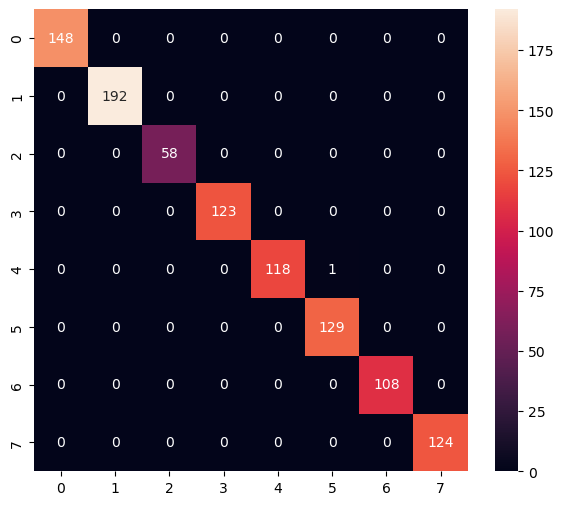

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       192
           2       1.00      1.00      1.00        58
           3       1.00      1.00      1.00       123
           4       1.00      0.99      1.00       119
           5       0.99      1.00      1.00       129
           6       1.00      1.00      1.00       108
           7       1.00      1.00      1.00       124

    accuracy                           1.00      1001
   macro avg       1.00      1.00      1.00      1001
weighted avg       1.00      1.00      1.00      1001



In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

<p>TRAINING LOSS AFTER EPOCH</p>

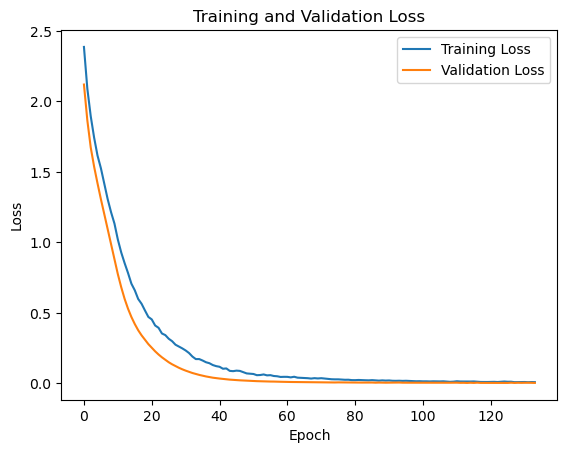

In [128]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<p>SAVE MODEL</p>

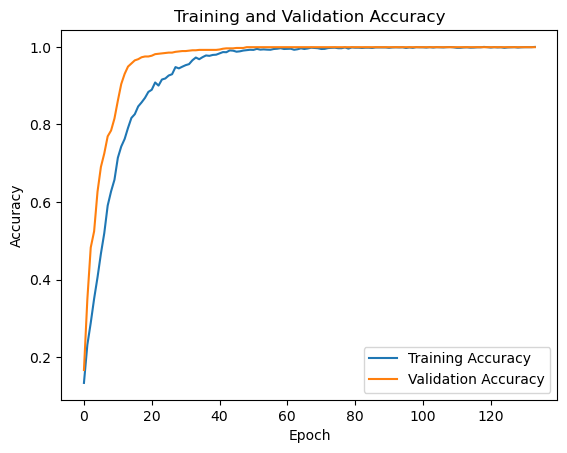

In [129]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [130]:
model.save(model_save_path)

INFO:tensorflow:Assets written to: model/keypoint_classifier\assets


INFO:tensorflow:Assets written to: model/keypoint_classifier\assets


In [131]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)
model_config = model.get_config()
import json
# Serialize dictionary to JSON
model_json = json.dumps(model_config)

# Save JSON to a file
# with open(tfjson_save_path, 'w') as json_file:
#     json_file.write(model_json)

# with open(tfbin_save_path, 'wb') as f:
#     for layer in model.layers:
#         for weight in layer.get_weights():
#             np.array(weight).tofile(f)


INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmpcudjelai\assets


INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmpcudjelai\assets
